In [1]:
import numpy as np
import struct
from array import array
from os.path  import join
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import decomposition
from scipy.spatial import Voronoi, voronoi_plot_2d
import torch
from torch.autograd import grad
import torch.nn.functional as F
import matplotlib.patches as p

In [3]:
# Setting up the path for the data files
in_path = './archive'
train_images = join(in_path, 
    'train-images-idx3-ubyte/train-images-idx3-ubyte')
train_labels = join(in_path,
    'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images = join(in_path, 
    't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels = join(in_path, 
    't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

In [4]:
# Defining a class for loading and processing the MNIST dataset
class MnistDataloader(object):
    def __init__(self, training_images, training_labels, test_images, test_labels):
        self.training_images = training_images
        self.training_labels = training_labels
        self.test_images = test_images
        self.test_labels = test_labels
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        # Read and process label data
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            labels = array("B", file.read())
        # Read and process image data        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img
        
        return images, labels

    def load_data(self):
        # Load training and testing data
        x_train, y_train = self.read_images_labels(self.training_images, self.training_labels)
        x_test, y_test = self.read_images_labels(self.test_images, self.test_labels)
        return (x_train, y_train),(x_test, y_test)

In [5]:
# Defining a class for the Autoencoder model
class AutoEncoder():
    def __init__(self, dims, activation_list=None):
        self.layers = len(dims)-1
        self.params = {}

        # Initializing weights and biases
        for l in range(self.layers):
            self.params["W"+str(l+1)] = 0.01*torch.randn(dims[l], dims[l+1], requires_grad=True, dtype=torch.float32)
            self.params["b"+str(l+1)] = torch.zeros((dims[l+1], 1), requires_grad=True, dtype=torch.float32)

    def forward(self, x):
        # Forward pass through the network layers
        x = torch.mm(self.params["W1"].T, x.T) + self.params["b1"]
        x = relu(x)
        x = torch.mm(self.params["W2"].T, x) + self.params["b2"]
        x = relu(x)
        x = torch.mm(self.params["W3"].T, x) + self.params["b3"]
        x = relu(x)
        x = torch.mm(self.params["W4"].T, x) + self.params["b4"]
        x = relu(x)
        x = torch.mm(self.params["W5"].T, x) + self.params["b5"]
        x = relu(x)
        x = torch.mm(self.params["W6"].T, x) + self.params["b6"]
        return x

    def test(self, x):
        # Test pass through a subset of network layers
        x = torch.mm(self.params["W1"].T, x.T) + self.params["b1"]
        x = relu(x)
        x = torch.mm(self.params["W2"].T, x) + self.params["b2"]
        x = relu(x)
        x = torch.mm(self.params["W3"].T, x) + self.params["b3"]
        return x

In [6]:
# Defining the ReLU activation function
def relu(z):
    A = torch.clamp(z, min=0.0, max=float('inf'))
    return A

# Function for training the model
def train(model, x, labels, epochs=20, l_rate=0.1, seed=1):
    cost = []
    torch.manual_seed(seed)

    for i in range(epochs):
        logits = model.forward(x)

        # Computing the loss and recording it
        loss = F.cross_entropy(logits.transpose(0, 1), labels.long())  # using Mean Squared Error (MSE) loss might not be suitable
        cost.append(loss.detach())

        # Logging loss every 5 epochs
        if not i % 5 == 0: # adjusted to every 5
            print('epoch: %02d | Loss: %.5f' % ((i + 1), loss.item()))

        # Calculating gradients and updating parameters(changed for code efficiency)
        gradients = grad(loss, list(model.params.values()), create_graph=True)
        with torch.no_grad():
            for j, param in enumerate(model.params.values()):
                param -= l_rate * gradients[j]
    return cost

# Function to calculate the sum of diagonal elements in a confusion matrix
def getSum(cm):
    sum = 0
    for i in range(10):
        sum += cm[i][i]
    return sum

# Function to split data into Voronoi cells
def voronoi_split(x, y):
    out = [[0, 0] for i in range(10)]
    count = [0 for i in range(10)]
    # Aggregating coordinates for each label
    for i in range(len(y)):
        out[y[i]][0] += x[y[i]][0]
        out[y[i]][1] += x[y[i]][1]
        count[y[i]] += 1
    # Averaging coordinates for each label
    for i in range(10):
        out[i][0] /= count[i]
        out[i][1] /= count[i]

    return out

Accuracy:  0.9665


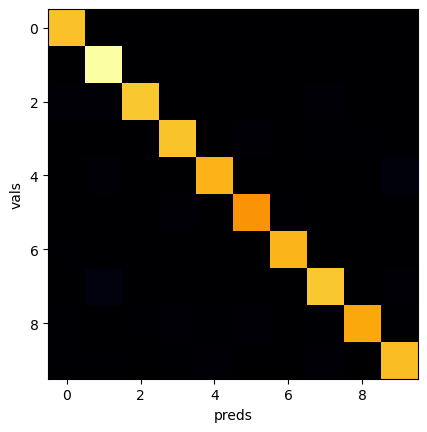

<Figure size 640x480 with 0 Axes>

In [7]:
########## Begin Main Script ##########
# Loading the MNIST dataset
mndl = MnistDataloader(train_images, train_labels, test_images, test_labels)
(x_train, y_train), (x_test, y_test) = mndl.load_data()

# Preprocessing the dataset
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

# Training and evaluating a K-Nearest Neighbors Classifier
knn = KNeighborsClassifier(n_neighbors=10) # tried lower values for n_neighbors
knn.fit(x_train, y_train)

# Predicting and evaluating the KNN model
pred_y = knn.predict(x_test)
cm = confusion_matrix(y_test, pred_y)
s = getSum(cm)
print("Accuracy: ", s/10000)

# Visualizing the confusion matrix
plt.imshow(cm, cmap = 'inferno', interpolation='nearest')
plt.xlabel('preds')
plt.ylabel('vals')
plt.show()
plt.clf()

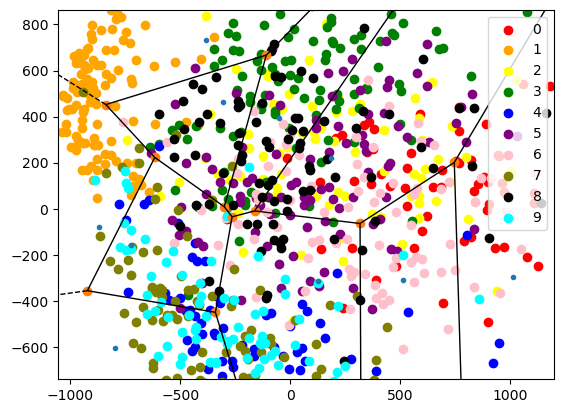

Accuracy[ 1 ]:  0.1073


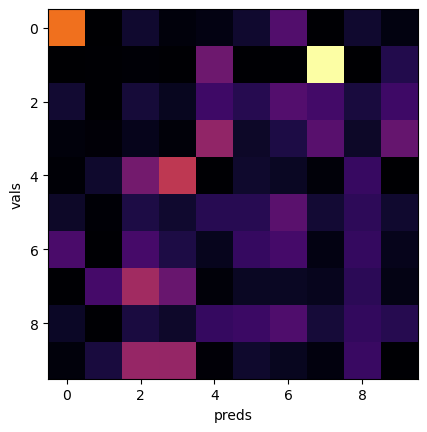

Accuracy[ 10 ]:  0.1187


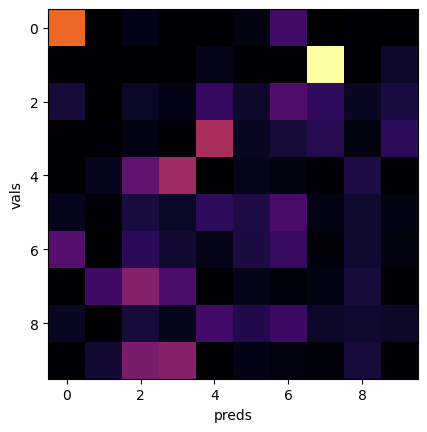

Accuracy[ 20 ]:  0.1194


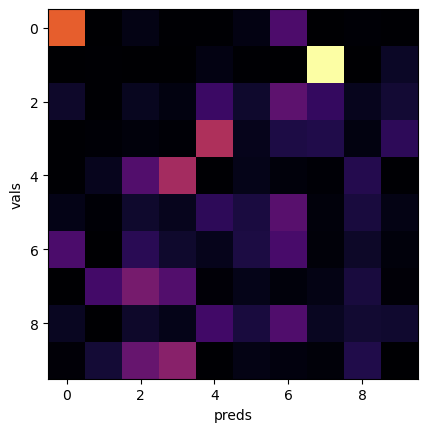

Accuracy[ 50 ]:  0.1216


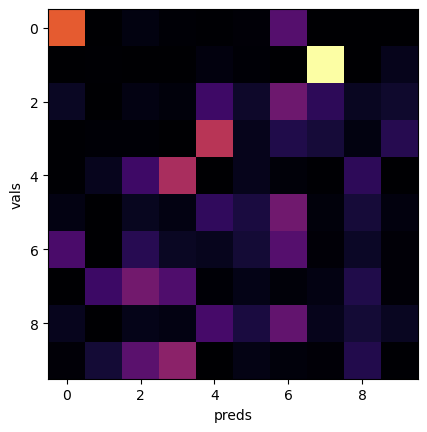

Accuracy[ 100 ]:  0.1201


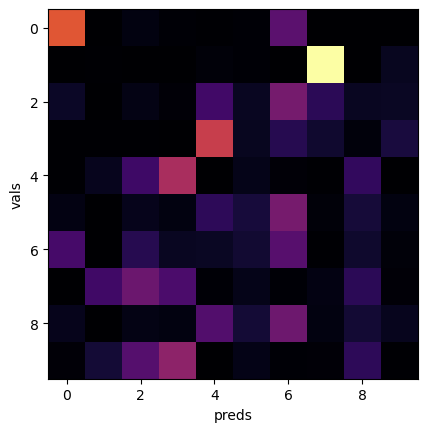

<Figure size 640x480 with 0 Axes>

In [8]:
# Exploring different dimensions for PCA
dimensions = [1, 10, 20, 50, 100]
pca = decomposition.PCA()
pca.n_components = 2
pca_transform = pca.fit_transform(x_test)
pca_train = pca.fit_transform(x_train)
plot = voronoi_split(pca_train, y_train)
v = Voronoi(plot)
fig = voronoi_plot_2d(v)

# Visualizing data points in PCA-transformed space
point_list = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
c_list = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'olive', 'black', 'cyan']
for i in range(0, len(y_test), 10):
    point_list[2*y_test[i]].append(pca_transform[i][0])
    point_list[2*y_test[i]+1].append(pca_transform[i][1])

for i in range(0, 10):
    plt.scatter(point_list[2*i], point_list[2*i+1], color=c_list[i], label=i)

plt.legend()
plt.show()
plt.clf()

# Repeating KNN classification with different PCA dimensions
pca.n_components = 2
pca_transform = pca.fit_transform(x_train)
pca_test = pca.fit_transform(x_test)

# Looping through different dimensions for KNN classification
for i in range(len(dimensions)):
    knn = KNeighborsClassifier(n_neighbors=dimensions[i])
    knn.fit(pca_transform, y_train)
    pred_y = knn.predict(pca_test)
    cm = confusion_matrix(y_test, pred_y)
    s = getSum(cm)
    print("Accuracy[", dimensions[i],"]: ", s/10000)

    # Plotting and displaying the confusion matrix
    plt.imshow(cm, cmap = 'inferno', interpolation='nearest')
    plt.xlabel('preds')
    plt.ylabel('vals')
    plt.show()
    plt.clf()

# Converting datasets to tensors for PyTorch  
y_aux = y_train
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Setting seed and training parameters for the AutoEncoder
seed = 1
torch.manual_seed(seed)
epochs = 500
l_rate = 0.05

# Dimensions for the AutoEncoder layers
dims = [784, 300, 100, 2, 100, 300, 10] # output layer with dimmension of 10

# Initializing AutoEncoder model
model = AutoEncoder(dims)
cost = train(model, x_train, y_train)

# Testing the AutoEncoder model and converting outputs to numpy arrays
ae_dataset_test = model.test(x_test).detach().numpy()
ae_dataset_train = model.test(x_train).detach().numpy()

# Creating Voronoi plots for the AutoEncoder's output
plot = voronoi_split(ae_dataset_train.T, y_aux)
v = Voronoi(plot)
v = voronoi_plot_2d(v)

In [ ]:
# Preparing data for scatter plot
point_list = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
c_list = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink', 'olive', 'black', 'cyan']

# Plotting each point in the AutoEncoder's test dataset
for i in range(0, len(y_test), 10):
    point_list[2*y_aux[i]].append(ae_dataset_test[0][i])
    point_list[2*y_aux[i]+1].append(ae_dataset_test[1][i])

# Scatter plot of the AutoEncoder's output
for i in range(0, 10):
    plt.scatter(point_list[2*i], point_list[2*i+1], color=c_list[i], label=i)

plt.legend()
plt.show()
plt.clf()

In [ ]:
# Repeating KNN classification with AutoEncoder output
for i in range(len(dimensions)):
    knn = KNeighborsClassifier(n_neighbors=dimensions[i])
    knn.fit(ae_dataset_train.T, y_train)
    pred_y = knn.predict(ae_dataset_test.T)

    cm = confusion_matrix(y_test, pred_y)
    s = getSum(cm)
    print("Accuracy[", dimensions[i],"]: ", s/10000)

    # Plotting and displaying the confusion matrix
    plt.imshow(cm, cmap = 'inferno', interpolation='nearest')
    plt.xlabel('preds')
    plt.ylabel('vals')
    plt.show()
    plt.clf()